<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [27]</a>'.</span>

# Load Data

In [1]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

# TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 100

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 6
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet18.a1_in1k"
    epochs = 5
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 32
    # gradient_accumulation_steps = 1

    lr = 5e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 200
    frozen_layers = 0

In [5]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

wandb: Currently logged in as: aakashks_. Use `wandb login --relogin` to force relogin


wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.16.5


wandb: Run data is saved locally in /scratch/aakash_ks.iitr/dr-scnn/wandb/run-20240513_025250-aewvfuy4
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run firm-surf-107


wandb: ⭐️ View project at https://wandb.ai/aakashks_/hello-world


wandb: 🚀 View run at https://wandb.ai/aakashks_/hello-world/runs/aewvfuy4/workspace


In [6]:
device = torch.device(CFG.device)

# Load train data

In [7]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv')).sample(frac=1).reset_index(drop=True)
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,20452,20464,25810_left,0
1,34561,34578,43699_left,0
2,17338,17350,21803_left,0
3,16513,16523,20739_right,0
4,31809,31825,40201_right,0
...,...,...,...,...
35103,9580,9587,12075_right,0
35104,32210,32226,40707_left,0
35105,26816,26831,33941_right,0
35106,4907,4911,6175_right,1


In [8]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)]
len(train_data)

19944

In [9]:
train_data.level.value_counts()

level
0    14637
2     2982
1     1405
3      498
4      422
Name: count, dtype: int64

In [10]:
# take only 100 samples from each class
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
train_data.level.value_counts()

level
0    200
4    200
2    200
1    200
3    200
Name: count, dtype: int64

# Dataset

In [11]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [12]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    v2.RandomApply([v2.ColorJitter(0.8, 0.8, 0.8, 0.4)], p=0.6),
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    CustomTransform(),
    # v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    # v2.RandomGrayscale(p=0.2),
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [13]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

In [14]:
class ContrastiveLearningDataset(Dataset):
    def __init__(self, folder, data, transform=None):
        self.folder = folder
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.folder}{self.data.loc[idx, 'image']}.jpeg"
        label = self.data.loc[idx, 'level']
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            xi = self.transform(image)
            xj = self.transform(image)  # Apply the same transform twice
        else:
            xi = xj = image

        return xi, xj, torch.tensor(label, dtype=torch.long)

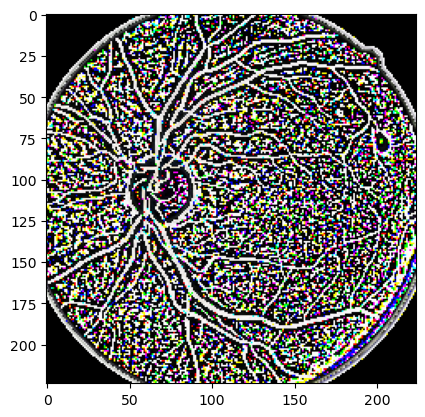

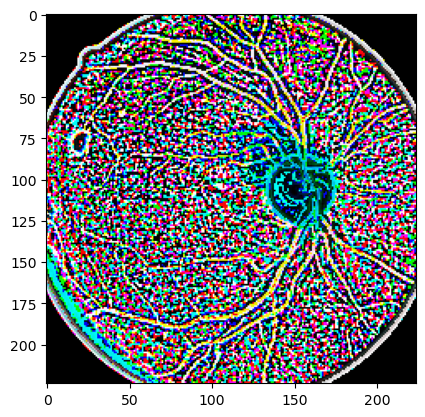

tensor(0)

In [15]:
# visualize the transformations
train_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, train_data, train_transforms)
img1, img2, label = train_dataset[9]
transformed_img_pil = func.to_pil_image(img1)
plt.imshow(transformed_img_pil)
plt.show()

transformed_img_pil_2 = func.to_pil_image(img2)
plt.imshow(transformed_img_pil_2)
plt.show()
label

# Metric

In [16]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score

In [17]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.1, device='cuda'):
        super().__init__()
        self.temperature = temperature
        self.device = device

    def forward(self, z_i, z_j, labels):
        batch_size = z_i.size(0)
        
        # Move tensors to the specified device
        z_i = z_i.to(self.device)
        z_j = z_j.to(self.device)
        labels = labels.to(self.device)
        
        # Concatenate the representations
        z = torch.cat([z_i, z_j], dim=0)
        labels = torch.cat([labels, labels], dim=0)
        
        # Compute the cosine similarity
        sim_matrix = torch.mm(z, z.t().contiguous()) / self.temperature
        
        # Mask-out self similarities
        sim_matrix.fill_diagonal_(0)
        
        # Compute the exponent of similarities for stability
        exp_sim = torch.exp(sim_matrix)

        # Create a mask for positive samples
        positive_mask = labels.unsqueeze(0) == labels.unsqueeze(1)
        positive_mask.fill_diagonal_(0)
        
        # Compute sum of exps for positive examples
        positives = exp_sim * positive_mask
        positives_sum = positives.sum(1)

        # Handling no positive cases
        valid_positives = positives_sum > 0
        positives_sum = positives_sum[valid_positives]

        # Avoid division by zero
        if positives_sum.nelement() == 0:
            return torch.tensor(0.0, device=self.device, requires_grad=True)

        # Compute log probability
        log_prob = torch.log(positives_sum) - torch.log(exp_sim.sum(1)[valid_positives])

        # Calculate loss as negative log of mean probability
        loss = -log_prob.mean()
        return loss

# Train and evaluate functions

In [18]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [19]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [20]:
def evaluate_model(cfg, feature_extractor, projection_head, loader, device):
    feature_extractor.eval()
    projection_head.eval()
    
    embeddings = []
    labels = []

    with torch.no_grad():
        for (images, image_labels) in loader:
            images = images.to(device)
            projected_embeddings = projection_head(feature_extractor(images))
            embeddings.append(projected_embeddings)
            labels.append(image_labels)

    # Concatenate all embeddings and labels collected through the DataLoader
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    
    # Calculate pairwise cosine similarity
    similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)

    # Evaluate the embeddings (example evaluation: Precision@1)
    correct = 0
    total = 0
    
    # Iterate over each row in similarity matrix, exclude self-similarity
    for i in range(len(labels)):
        similarities = similarity_matrix[i]
        similar_indices = (labels == labels[i]).nonzero(as_tuple=False).squeeze()
        similar_indices = similar_indices[similar_indices != i]  # Remove self-index
        
        if not similar_indices.size(0):
            continue

        # Get the index with the highest similarity score excluding itself
        _, max_index = similarities[similar_indices].max(dim=0)
        predicted_index = similar_indices[max_index]
        
        if labels[predicted_index] == labels[i]:
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"Evaluation Accuracy: {accuracy:.4f}")
    
    return accuracy

In [21]:
def train_epoch(cfg, feature_extractor, projection_head, train_loader, loss_fn, device, optimizer, scheduler, epoch):  
    feature_extractor.train()
    projection_head.train()

    train_loss = 0
    learning_rate_history = []
    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)

    for step, (xi, xj, label) in tk0:
        xi, xj = xi.to(device), xj.to(device)
        
        optimizer.zero_grad()
        
        zi = projection_head(feature_extractor(xi))
        zj = projection_head(feature_extractor(xj))
        
        loss = loss_fn(zi, zj, label)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Update learning rate scheduler if present
        if scheduler is not None:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimizer.param_groups[0]['lr']
        
        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

    train_loss /= total_len

    print(f'Epoch {epoch}: training loss = {train_loss:.4f}')
    return train_loss, learning_rate_history

# Train model

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='level', ylabel='Count'>

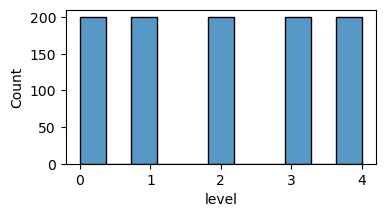

In [22]:
plt.figure(figsize=(4,2))
sns.histplot(train_data["level"])

In [23]:
def create_model():
    model = timm.create_model(CFG.model_name, num_classes=0, pretrained=True)
    # freeze_initial_layers(model, freeze_up_to_layer=CFG.frozen_layers)
    return model.to(device)

In [24]:
# Define the projection head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [25]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def get_embeddings(model, data_loader):
    model.eval()

    features = []
    targets = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            embds = model(images)

            features.append(embds.detach().cpu())
            targets.append(target.detach().cpu())

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # store the embeddings for future use
    torch.save(features, os.path.join(wandb.run.dir, f"embeddings.pth"))
    torch.save(targets, os.path.join(wandb.run.dir, f"targets.pth"))

    return features, targets


def plot_tsne(embeddings, labels):
    # Apply t-SNE to the embeddings
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings.numpy())

    # Define the number of unique labels/classes
    num_classes = len(np.unique(labels.numpy()))
    # Create a custom color map with specific color transitions
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=num_classes)

    # Create a boundary norm with boundaries and colors
    norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 0.5, 1), cmap.N)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
    colorbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
    colorbar.set_label('Severity Level')
    colorbar.set_ticklabels(np.arange(num_classes))  # Set discrete labels if needed
    plt.title('t-SNE of Image Embeddings with Discrete Severity Levels')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.savefig(os.path.join(wandb.run.dir, f"tsne.png"), dpi=300, bbox_inches='tight')


## Train folds

In [26]:
from sklearn.model_selection import StratifiedKFold

sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image"].values, train_data["level"].values)):
    train_data.loc[test_index, "fold"] = i

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [27]:
for FOLD in CFG.train_folds:
    seed_everything(CFG.seed)

    # Prepare datasets and data loaders
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    train_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, fold_train_data, transform=train_transforms)
    valid_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=True
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )

    # Prepare model, optimizer, and scheduler
    model = create_model()
    projection_head = ProjectionHead(input_dim=512, output_dim=128).to(device)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(projection_head.parameters()), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=26, gamma=0.5)

    criterion = NTXentLoss(temperature=0.5)

    best_acc = 0
    no_improve_epochs = 0
    patience = 5  # Number of epochs to wait before stopping if no improvement
    wandb.run.tags = [f"fold_{FOLD}"]

    for epoch in range(CFG.epochs):
        train_loss, train_lr = train_epoch(
            CFG, model, projection_head, train_loader, criterion, device, optimizer, scheduler, epoch
        )

        val_accuracy = evaluate_model(
            CFG, model, projection_head, valid_loader, device
        )

        if (val_accuracy > best_acc):
            print(f"{style.GREEN}New best loss: {best_acc:.4f} -> {val_accuracy:.4f}{style.END}")
            best_acc = val_accuracy
            no_improve_epochs = 0  # Reset the counter since we improved
            torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'best_model_fold_{FOLD}.pth'))
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs")

        if no_improve_epochs >= patience:
            print(f"Stopping early after {no_improve_epochs} epochs without improvement")
            break

        scheduler.step()  # Update the learning rate scheduler at the end of each epoch


    # plot a tsne plot of all the images using embeddings from the model
    full_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transforms=val_transforms)
    loader = DataLoader(
        full_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )
    
    features, targets = get_embeddings(model, loader)
    plot_tsne(features, targets)


  0%|                                                                              | 0/26 [00:00<?, ?it/s]

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853099/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

Epoch 0 training 1/26 [LR 0.005000] - loss: 1.6009:   0%|                          | 0/26 [01:49<?, ?it/s]


Epoch 0 training 1/26 [LR 0.005000] - loss: 1.6009:   4%|▋                | 1/26 [01:49<45:33, 109.36s/it]


Epoch 0 training 2/26 [LR 0.002500] - loss: 1.6706:   4%|▋                | 1/26 [01:49<45:33, 109.36s/it]


Epoch 0 training 3/26 [LR 0.002500] - loss: 3.2328:   4%|▋                | 1/26 [01:49<45:33, 109.36s/it]


Epoch 0 training 3/26 [LR 0.002500] - loss: 3.2328:  12%|██                | 3/26 [01:49<10:53, 28.41s/it]


Epoch 0 training 4/26 [LR 0.001250] - loss: 3.3138:  12%|██                | 3/26 [01:49<10:53, 28.41s/it]


Epoch 0 training 5/26 [LR 0.001250] - loss: 2.9686:  12%|██                | 3/26 [01:49<10:53, 28.41s/it]


Epoch 0 training 5/26 [LR 0.001250] - loss: 2.9686:  19%|███▍              | 5/26 [01:49<04:50, 13.84s/it]


Epoch 0 training 6/26 [LR 0.000625] - loss: 2.7499:  19%|███▍              | 5/26 [01:49<04:50, 13.84s/it]


Epoch 0 training 7/26 [LR 0.000625] - loss: 2.5946:  19%|███▍              | 5/26 [01:49<04:50, 13.84s/it]


Epoch 0 training 7/26 [LR 0.000625] - loss: 2.5946:  27%|████▊             | 7/26 [01:49<02:32,  8.01s/it]


Epoch 0 training 8/26 [LR 0.000313] - loss: 2.4825:  27%|████▊             | 7/26 [01:49<02:32,  8.01s/it]


Epoch 0 training 9/26 [LR 0.000313] - loss: 2.3957:  27%|████▊             | 7/26 [01:49<02:32,  8.01s/it]


Epoch 0 training 9/26 [LR 0.000313] - loss: 2.3957:  35%|██████▏           | 9/26 [01:49<01:25,  5.02s/it]


Epoch 0 training 10/26 [LR 0.000156] - loss: 2.3260:  35%|█████▉           | 9/26 [01:50<01:25,  5.02s/it]


Epoch 0 training 11/26 [LR 0.000156] - loss: 2.2633:  35%|█████▉           | 9/26 [01:50<01:25,  5.02s/it]


Epoch 0 training 11/26 [LR 0.000156] - loss: 2.2633:  42%|██████▊         | 11/26 [01:50<00:49,  3.29s/it]


Epoch 0 training 12/26 [LR 0.000078] - loss: 2.2100:  42%|██████▊         | 11/26 [01:50<00:49,  3.29s/it]


Epoch 0 training 13/26 [LR 0.000078] - loss: 2.1674:  42%|██████▊         | 11/26 [01:50<00:49,  3.29s/it]


Epoch 0 training 13/26 [LR 0.000078] - loss: 2.1674:  50%|████████        | 13/26 [01:50<00:28,  2.22s/it]


Epoch 0 training 14/26 [LR 0.000039] - loss: 2.1237:  50%|████████        | 13/26 [01:50<00:28,  2.22s/it]


Epoch 0 training 15/26 [LR 0.000039] - loss: 2.0895:  50%|████████        | 13/26 [01:50<00:28,  2.22s/it]


Epoch 0 training 15/26 [LR 0.000039] - loss: 2.0895:  58%|█████████▏      | 15/26 [01:50<00:16,  1.53s/it]


Epoch 0 training 16/26 [LR 0.000020] - loss: 2.0567:  58%|█████████▏      | 15/26 [01:50<00:16,  1.53s/it]


Epoch 0 training 16/26 [LR 0.000020] - loss: 2.0567:  58%|█████████▏      | 15/26 [02:09<00:16,  1.53s/it]


Epoch 0 training 17/26 [LR 0.000020] - loss: 2.0218:  58%|█████████▏      | 15/26 [03:19<00:16,  1.53s/it]


Epoch 0 training 17/26 [LR 0.000020] - loss: 2.0218:  65%|██████████▍     | 17/26 [03:19<02:16, 15.17s/it]


Epoch 0 training 18/26 [LR 0.000010] - loss: 2.0016:  65%|██████████▍     | 17/26 [03:30<02:16, 15.17s/it]


Epoch 0 training 18/26 [LR 0.000010] - loss: 2.0016:  69%|███████████     | 18/26 [03:30<01:54, 14.36s/it]


Epoch 0 training 19/26 [LR 0.000010] - loss: 1.9775:  69%|███████████     | 18/26 [03:30<01:54, 14.36s/it]


Epoch 0 training 20/26 [LR 0.000005] - loss: 1.9577:  69%|███████████     | 18/26 [03:30<01:54, 14.36s/it]


Epoch 0 training 20/26 [LR 0.000005] - loss: 1.9577:  77%|████████████▎   | 20/26 [03:30<00:56,  9.44s/it]


Epoch 0 training 21/26 [LR 0.000005] - loss: 1.9415:  77%|████████████▎   | 20/26 [03:30<00:56,  9.44s/it]


Epoch 0 training 22/26 [LR 0.000002] - loss: 1.9275:  77%|████████████▎   | 20/26 [03:31<00:56,  9.44s/it]


Epoch 0 training 22/26 [LR 0.000002] - loss: 1.9275:  85%|█████████████▌  | 22/26 [03:31<00:25,  6.35s/it]


Epoch 0 training 23/26 [LR 0.000002] - loss: 1.9145:  85%|█████████████▌  | 22/26 [03:31<00:25,  6.35s/it]


Epoch 0 training 24/26 [LR 0.000001] - loss: 1.9037:  85%|█████████████▌  | 22/26 [03:31<00:25,  6.35s/it]


Epoch 0 training 24/26 [LR 0.000001] - loss: 1.9037:  92%|██████████████▊ | 24/26 [03:31<00:08,  4.34s/it]


Epoch 0 training 25/26 [LR 0.000001] - loss: 1.8913:  92%|██████████████▊ | 24/26 [03:31<00:08,  4.34s/it]


Epoch 0 training 26/26 [LR 0.000001] - loss: 1.8796:  92%|██████████████▊ | 24/26 [03:31<00:08,  4.34s/it]


Epoch 0 training 26/26 [LR 0.000001] - loss: 1.8796: 100%|████████████████| 26/26 [03:31<00:00,  3.00s/it]


Epoch 0 training 26/26 [LR 0.000001] - loss: 1.8796: 100%|████████████████| 26/26 [03:31<00:00,  8.13s/it]

Epoch 0: training loss = 1.8796


Evaluation Accuracy: 1.0000
New best loss: 0.0000 -> 1.0000



  0%|                                                                              | 0/26 [00:00<?, ?it/s]


Epoch 1 training 1/26 [LR 0.000000] - loss: 1.6232:   0%|                          | 0/26 [01:41<?, ?it/s]


Epoch 1 training 1/26 [LR 0.000000] - loss: 1.6232:   4%|▋                | 1/26 [01:41<42:22, 101.72s/it]


Epoch 1 training 2/26 [LR 0.000000] - loss: 1.5691:   4%|▋                | 1/26 [01:42<42:22, 101.72s/it]


Epoch 1 training 2/26 [LR 0.000000] - loss: 1.5691:   8%|█▍                | 2/26 [01:42<17:02, 42.61s/it]


Epoch 1 training 3/26 [LR 0.000000] - loss: 1.5488:   8%|█▍                | 2/26 [01:43<17:02, 42.61s/it]


Epoch 1 training 3/26 [LR 0.000000] - loss: 1.5488:  12%|██                | 3/26 [01:43<09:01, 23.56s/it]


Epoch 1 training 4/26 [LR 0.000000] - loss: 1.5645:  12%|██                | 3/26 [01:46<09:01, 23.56s/it]


Epoch 1 training 4/26 [LR 0.000000] - loss: 1.5645:  15%|██▊               | 4/26 [01:46<05:39, 15.42s/it]


Epoch 1 training 5/26 [LR 0.000000] - loss: 1.5818:  15%|██▊               | 4/26 [01:48<05:39, 15.42s/it]


Epoch 1 training 5/26 [LR 0.000000] - loss: 1.5818:  19%|███▍              | 5/26 [01:48<03:39, 10.45s/it]


Epoch 1 training 6/26 [LR 0.000000] - loss: 1.5948:  19%|███▍              | 5/26 [01:48<03:39, 10.45s/it]


Epoch 1 training 7/26 [LR 0.000000] - loss: 1.6132:  19%|███▍              | 5/26 [01:49<03:39, 10.45s/it]


Epoch 1 training 7/26 [LR 0.000000] - loss: 1.6132:  27%|████▊             | 7/26 [01:49<01:41,  5.34s/it]


Epoch 1 training 8/26 [LR 0.000000] - loss: 1.6160:  27%|████▊             | 7/26 [01:49<01:41,  5.34s/it]


Epoch 1 training 9/26 [LR 0.000000] - loss: 1.6162:  27%|████▊             | 7/26 [01:49<01:41,  5.34s/it]


Epoch 1 training 9/26 [LR 0.000000] - loss: 1.6162:  35%|██████▏           | 9/26 [01:49<00:53,  3.12s/it]


Epoch 1 training 10/26 [LR 0.000000] - loss: 1.6157:  35%|█████▉           | 9/26 [01:49<00:53,  3.12s/it]


Epoch 1 training 11/26 [LR 0.000000] - loss: 1.6246:  35%|█████▉           | 9/26 [01:49<00:53,  3.12s/it]


Epoch 1 training 11/26 [LR 0.000000] - loss: 1.6246:  42%|██████▊         | 11/26 [01:49<00:29,  1.98s/it]


Epoch 1 training 12/26 [LR 0.000000] - loss: 1.6252:  42%|██████▊         | 11/26 [01:49<00:29,  1.98s/it]


Epoch 1 training 13/26 [LR 0.000000] - loss: 1.6230:  42%|██████▊         | 11/26 [01:49<00:29,  1.98s/it]


Epoch 1 training 13/26 [LR 0.000000] - loss: 1.6230:  50%|████████        | 13/26 [01:49<00:17,  1.31s/it]


Epoch 1 training 14/26 [LR 0.000000] - loss: 1.6207:  50%|████████        | 13/26 [01:49<00:17,  1.31s/it]


Epoch 1 training 15/26 [LR 0.000000] - loss: 1.6211:  50%|████████        | 13/26 [01:49<00:17,  1.31s/it]


Epoch 1 training 15/26 [LR 0.000000] - loss: 1.6211:  58%|█████████▏      | 15/26 [01:49<00:09,  1.11it/s]


Epoch 1 training 16/26 [LR 0.000000] - loss: 1.6187:  58%|█████████▏      | 15/26 [01:49<00:09,  1.11it/s]


Epoch 1 training 16/26 [LR 0.000000] - loss: 1.6187:  58%|█████████▏      | 15/26 [02:00<00:09,  1.11it/s]


Epoch 1 training 17/26 [LR 0.000000] - loss: 1.6225:  58%|█████████▏      | 15/26 [03:11<00:09,  1.11it/s]


Epoch 1 training 17/26 [LR 0.000000] - loss: 1.6225:  65%|██████████▍     | 17/26 [03:11<02:04, 13.84s/it]


Epoch 1 training 18/26 [LR 0.000000] - loss: 1.6224:  65%|██████████▍     | 17/26 [03:11<02:04, 13.84s/it]


Epoch 1 training 19/26 [LR 0.000000] - loss: 1.6234:  65%|██████████▍     | 17/26 [03:19<02:04, 13.84s/it]


Epoch 1 training 19/26 [LR 0.000000] - loss: 1.6234:  73%|███████████▋    | 19/26 [03:19<01:15, 10.72s/it]


Epoch 1 training 20/26 [LR 0.000000] - loss: 1.6248:  73%|███████████▋    | 19/26 [03:19<01:15, 10.72s/it]


Epoch 1 training 21/26 [LR 0.000000] - loss: 1.6287:  73%|███████████▋    | 19/26 [03:19<01:15, 10.72s/it]


Epoch 1 training 21/26 [LR 0.000000] - loss: 1.6287:  81%|████████████▉   | 21/26 [03:19<00:37,  7.41s/it]


Epoch 1 training 22/26 [LR 0.000000] - loss: 1.6280:  81%|████████████▉   | 21/26 [03:19<00:37,  7.41s/it]


Epoch 1 training 23/26 [LR 0.000000] - loss: 1.6247:  81%|████████████▉   | 21/26 [03:20<00:37,  7.41s/it]


Epoch 1 training 23/26 [LR 0.000000] - loss: 1.6247:  88%|██████████████▏ | 23/26 [03:20<00:15,  5.16s/it]


Epoch 1 training 24/26 [LR 0.000000] - loss: 1.6207:  88%|██████████████▏ | 23/26 [03:20<00:15,  5.16s/it]


Epoch 1 training 25/26 [LR 0.000000] - loss: 1.6215:  88%|██████████████▏ | 23/26 [03:20<00:15,  5.16s/it]


Epoch 1 training 25/26 [LR 0.000000] - loss: 1.6215:  96%|███████████████▍| 25/26 [03:20<00:03,  3.60s/it]


Epoch 1 training 26/26 [LR 0.000000] - loss: 1.6201:  96%|███████████████▍| 25/26 [03:20<00:03,  3.60s/it]


Epoch 1 training 26/26 [LR 0.000000] - loss: 1.6201: 100%|████████████████| 26/26 [03:20<00:00,  7.71s/it]

Epoch 1: training loss = 1.6201


Evaluation Accuracy: 1.0000
No improvement for 1 epochs



  0%|                                                                              | 0/26 [00:00<?, ?it/s]


  0%|                                                                              | 0/26 [01:14<?, ?it/s]

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_34085/2569873523.py", line 17, in __getitem__
    xj = self.transform(image)  # Apply the same transform twice
         ^^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/v2/_container.py", line 51, in forward
    outputs = transform(*inputs)
              ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_34085/3170054412.py", line 14, in __call__
    img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 350, in normalize
    return F_t.normalize(tensor, mean=mean, std=std, inplace=inplace)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/_functional_tensor.py", line 921, in normalize
    raise ValueError(f"std evaluated to zero after conversion to {dtype}, leading to division by zero.")
ValueError: std evaluated to zero after conversion to torch.float32, leading to division by zero.


In [ ]:
wandb.finish()